In [1]:
import pip

package_names = ['scorecardpy', 'awswrangler', 'sagemaker'] 
pip.main(['install'] + package_names + ['--upgrade'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


0

In [2]:
# Nativos
from dateutil.relativedelta import relativedelta
from time import gmtime, strftime
from datetime import datetime
import random as rn
import joblib
import json
import sys
import os
import gc

#nube
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker import get_execution_role
import awswrangler as wr
import sagemaker
import boto3

#calculo
import pandas as pd
import numpy as np
import scipy

#grafico
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

#Interacciones con output
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

gc.collect()
# MODELS
#from lightgbm import LGBMClassifier

BASE_DIR = os.path.dirname(os.getcwd())
if BASE_DIR not in sys.path: sys.path.append(BASE_DIR)
#import scorecardpy as sc


SEED = 29082013
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

### COnfig

In [3]:
from UTILITARIO_CODE.utils import targets

proyecto = 'propension'
normal = [1]
target = targets[7]
clasif = 'normal' if len(normal) == 1 else 'all'

now = datetime.now()
sess = sagemaker.session.Session()
s3 = boto3.resource('s3')
bucket = sess.default_bucket() 
region = boto3.Session().region_name

print("bucket: ", bucket)
print("region: ", region)
print("now: ", now)
print("target: ", target)

////////////////////////////////////////////////// 

path_container_input:  /opt/ml/processing/input
path_container_output:  /opt/ml/processing/output
path_container_utils:  /opt/ml/processing/input/utils
path_container_universo:  /opt/ml/processing/input/HM_UNIVERSO_PROPENSION_DESEMBOLSO_BPE
bucket:  sagemaker-us-east-1-058528764918
region:  us-east-1
now:  2021-08-02 19:33:24.019896
target:  target_desembolso_f2m_mayor_30_menor_180


### RUtas

In [4]:
uri_output = 's3://{}/vpc/{}/output'.format(bucket, proyecto)
print('uri_output: \n', uri_output)

select = '{}/seleccion_variables_{}_clasif_{}.csv'.format(uri_output, target.lower(), str(clasif))
woe = '{}/woe_{}_clasif_{}.json'.format(uri_output, target.lower(), clasif)
correlation = '{}/train_correlation_clasif_{}.csv'.format(uri_output, clasif)

print("select: \n", select)
print("woe: \n", woe)
print("correlation: \n", correlation)

uri_output: 
 s3://sagemaker-us-east-1-058528764918/vpc/propension/output
select: 
 s3://sagemaker-us-east-1-058528764918/vpc/propension/output/seleccion_variables_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.csv
woe: 
 s3://sagemaker-us-east-1-058528764918/vpc/propension/output/woe_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.json
correlation: 
 s3://sagemaker-us-east-1-058528764918/vpc/propension/output/train_correlation_clasif_normal.csv


### Correlation

In [5]:
matriz_corr = wr.s3.read_csv(
    correlation, 
    sep=','
)
matriz_corr.index = matriz_corr.columns
matriz_corr.head()

,target_desembolso_f2m_f3m_mayor_10_menor_180,target_desembolso_f2m_f3m_mayor_30_menor_180,target_desembolso_f2m_mayor_10_menor_180,target_desembolso_f2m_mayor_30_menor_180,monto_facturacion_mnt,monto_facturacion_prom_u3m,monto_facturacion_prom_u6m,monto_facturacion_prom_u9m,monto_deuda_agr_prom_u3m,monto_deuda_agr_prom_u6m,monto_deuda_agr_prom_u9m,monto_deuda_sf_prom_u3m,monto_deuda_sf_prom_u6m,monto_deuda_sf_prom_u9m,tendencia_monto_facturacion_ult_mes,tendencia_monto_deuda_agr_ult_mes,tendencia_monto_deuda_sf_ult_mes,tendencia_monto_facturacion_utl_trim,tendencia_monto_deuda_agr_utl_trim,tendencia_monto_deuda_sf_utl_trim,entidad_cnt,entidad_cnt_prom_u3m,entidad_cntn_prom_u6m,entidad_cnt_prom_u9m,nro_entidades_mayor_actual_u3m,nro_entidades_diff_actual_u2m,flg_cambio_banca_u3m,flg_cambio_banca_u6m,flg_cambio_banca_u9m,cnt_cambio_banca_u3m,cnt_cambio_banca_u6m,cnt_cambio_banca_u9m,flg_cambio_region_fin_u3m,flg_cambio_region_u6m,flg_cambio_region_u9m,flg_cambio_segemnto_fin_u3m,flg_cambio_segmento_u6m,saldo_ajustado_ult_rcc,max_saldo_ajustado_promedio_u3m,max_saldo_ajustado_promedio_u6m,max_saldo_ajustado_promedio_u9m,sum_saldo_ajustado_promedio_u3m,sum_saldo_ajustado_promedio_u6m,sum_saldo_ajustado_promedio_u9m,nro_entidades_9_meses_o_mas_con_saldo_ajustado,nro_entidades_8_meses_o_mas_con_saldo_ajustado,nro_entidades_7_meses_o_mas_con_saldo_ajustado,nro_entidades_6_meses_o_mas_con_saldo_ajustado,nro_entidades_5_meses_o_mas_con_saldo_ajustado,nro_entidades_4_meses_o_mas_con_saldo_ajustado,nro_entidades_3_meses_o_mas_con_saldo_ajustado,nro_entidades_2_meses_o_mas_con_saldo_ajustado,nro_entidades_1_meses_o_mas_con_saldo_ajustado,nro_entidades_ya_no_tiene_saldo_ajustado_u9m,nro_entidades_ya_no_tiene_saldo_ajustado_u6m,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,nro_entidades_termino_prestamo_u9m,nro_entidades_termino_prestamo_u6m,nro_entidades_termino_prestamo_u3m,nro_entidades_recien_3_meses_con_saldo_ajustado_u9m,nro_entidades_recien_2_meses_con_saldo_ajustado_u9m,nro_entidades_recien_1_mes_con_saldo_ajustado_u9m,nro_entidades_recien_3_meses_con_saldo_ajustado_u6m,nro_entidades_recien_2_meses_con_saldo_ajustado_u6m,nro_entidades_recien_1_mes_con_saldo_ajustado_u6m,ultima_variacion_saldo_ajustado,variacion_neta_saldo_ajustado_u3m,variacion_neta_saldo_ajustado_u6m,monto_adquirido_ult_rcc,monto_adquirido_u3m,monto_adquirido_u6m,monto_pagado_ult_rcc,monto_pagado_u3m,monto_pagado_u6m,saldo_col_vig,saldo_col_vig_ibk,saldo_col_vig_otros_bancos,saldo_col_vig_cajas,sow_ibk,sow_otros_bancos,sow_cajas,nro_tipo_entidad,nro_registros_reactiva_cajas,nro_registros_inmobiliario_cajas,nro_registros_garantias_cajas,nro_registros_reprogramados_cajas,nro_registros_fae_cajas,nro_registros_garantia_fae_cajas,nro_registros_coloc_indirectas_cajas,nro_registros_coloc_directas_cajas,nro_bancos_coloc_indirectas_no_ibk,nro_bancos_coloc_directas_no_ibk,nro_bancos_reprogramados_no_ibk,nro_bancos_garantias_no_ibk,nro_bancos_inmobiliario_no_ibk,nro_bancos_reactiva_no_ibk,nro_bancos_garantia_reactiva_no_ibk,nro_coloc_directas_ibk,nro_coloc_indirectas_ibk,nro_garantia_reactiva_ibk,nro_reactiva_ibk,nro_inmobiliario_ibk,nro_garantias_ibk,nro_reprogramados_ibk,flg_tiene_clasif_normal,flg_tiene_clasif_deficiente,flg_tiene_clasif_dudoso,flg_tiene_clasif_cpp,flg_tiene_clasif_perdida,saldo_reactiva,saldo_inmobiliario,saldo_coloc_indirectas,saldo_reprogramados,saldo_garantias,saldo_col_direct_vig_cajas,saldo_col_direct_vig_ibk,saldo_col_direct_vig_banco_no_ibk,saldo_col_direct_vig_competencia,percent_col_direct_competencia,percent_col_direct_bancos_no_ibk,percent_col_direct_ibk,percent_col_direct_cajas,saldo_col_indirect_competencia,saldo_col_indirect_vig_banco_no_ibk,saldo_col_indirect_ibk,saldo_col_indirect_cajas,percent_col_indirect_competencia,percent_col_indirect_bancos_no_ibk,percent_col_indirect_ibk,percent_col_indirect_cajas,saldo_col_direct_vig_venc,saldo_col_direct_castigado,saldo_col_direct_reestructurado,saldo_col_direct_refinanciado,saldo_col_direct_repro

In [6]:
top_correlacion = pd.DataFrame(matriz_corr[target].abs().sort_values(ascending=False))
top_correlacion.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target_desembolso_f2m_mayor_30_menor_180
target_desembolso_f2m_mayor_30_menor_180,1.00000
target_desembolso_f2m_f3m_mayor_30_menor_180,0.70275
target_desembolso_f2m_mayor_10_menor_180,0.70191
target_desembolso_f2m_f3m_mayor_10_menor_180,0.49359
monto_pagado_u6m,0.10552
monto_pagado_u3m,0.09363
nro_entidades_ya_no_tiene_saldo_ajustado_u3m,0.08822
nro_entidades_ya_no_tiene_saldo_ajustado_u9m,0.08816
nro_entidades_ya_no_tiene_saldo_ajustado_u6m,0.08572
sum_saldo_ajustado_promedio_u9m,0.07836


In [7]:
dict_correlation = top_correlacion.iloc[:].to_dict()[target]

### Selección iv / probabilidad

In [8]:
seleccion = wr.s3.read_csv(
    select, 
    sep=','
)
seleccion.head(20)

,ranking_iv,ranking_prob,variable,max_prob,iv,woe
0,0,4,monto_pagado_u6m,0.062362,0.598903,1.128554
1,1,5,variacion_neta_saldo_ajustado_u3m,0.061840,0.505218,1.119582
2,2,3,variacion_neta_saldo_ajustado_u6m,0.070551,0.498690,1.260697
3,3,6,ultima_variacion_saldo_ajustado,0.059949,0.497762,1.086521
4,4,15,monto_pagado_u3m,0.049531,0.463591,0.884596
5,5,113,flg_solo_normal,0.025375,0.421034,0.190664
6,6,116,flg_tiene_clasif_normal,0.024354,0.420606,0.148574
7,7,2,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,0.074261,0.334772,1.315955
8,8,118,max_dias_atraso_coloc_directas,0.023987,0.327163,0.133014
9,9,0,nro_entidades_ya_no_tiene_saldo_ajustado_u9m,0.107778,0.320926,1.725316


In [9]:
seleccion['correlation_spearman'] = seleccion['variable'].apply(lambda _: dict_correlation.get(_, 100))
seleccion = seleccion.sort_values(
    by=['correlation_spearman'], ascending=False).reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_corr'})

seleccion['ranking'] = seleccion[['ranking_prob', 'ranking_iv', 'ranking_corr']].mean(axis=1)
seleccion = seleccion.sort_values(by=['ranking'], ascending=True).reset_index(drop=True)

seleccion.head(30)

,ranking_corr,ranking_iv,ranking_prob,variable,max_prob,iv,woe,correlation_spearman,ranking
0,0,0,4,monto_pagado_u6m,0.062362,0.598903,1.128554,0.105525,1.333333
1,2,7,2,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,0.074261,0.334772,1.315955,0.088221,3.666667
2,3,9,0,nro_entidades_ya_no_tiene_saldo_ajustado_u9m,0.107778,0.320926,1.725316,0.088163,4.000000
3,4,10,1,nro_entidades_ya_no_tiene_saldo_ajustado_u6m,0.085595,0.312953,1.470316,0.085716,5.000000
4,7,3,6,ultima_variacion_saldo_ajustado,0.059949,0.497762,1.086521,0.073733,5.333333
5,13,1,5,variacion_neta_saldo_ajustado_u3m,0.061840,0.505218,1.119582,0.062261,6.333333
6,1,4,15,monto_pagado_u3m,0.049531,0.463591,0.884596,0.093625,6.666667
7,18,2,3,variacion_neta_saldo_ajustado_u6m,0.070551,0.498690,1.260697,0.058388,7.666667
8,5,16,36,sum_saldo_ajustado_promedio_u9m,0.038067,0.237747,0.609365,0.078359,19.000000
9,22,12,26,saldo_col_vig,0.042842,0.256844,0.732516,0.056528,20.000000


In [10]:
def corr_detail(df_corr, min_value=0.85, show_detail=True, col_target='target'):
    
    corr_taret = df_corr[col_target].sort_values(ascending=False).apply(lambda _: abs(_)).sort_values(ascending=False)
    
    from itertools import combinations
    def add_dicc(key, val, num, dicc):
        if key in dicc:
            dicc[key].append((val, num))
        else:
            dicc[key] = [(val, num)]
        
    set_unique, list_detected = set(), []
    dicc_detected = {}
    

    for cols in combinations(list(df_corr.columns), 2):
        corr_columns = np.fabs(df_corr[cols[0]][cols[1]])
        
        if corr_columns >= min_value:
            set_unique.update(cols)
            list_detected.extend(list(cols))
            add_dicc(cols[0], cols[1], corr_columns, dicc_detected)
            add_dicc(cols[1], cols[0], corr_columns, dicc_detected)        
            
    print("ANALISIS CORRELACION ENTRE COLUMNAS :")
    columnas_aparece = []
    cols_del = []
    for colc, cant in sorted(
        [(col, list_detected.count(col)) for col in set_unique], key=lambda _: _[1], reverse=True):
        
        if colc not in columnas_aparece:
            print("/"*30)
            print("-> ", colc, ' :::: ',cant, ' ///// ', corr_taret[colc])
            columnas_aparece.append(colc)
            if show_detail:
                for _ in dicc_detected[colc]:
                    print(" "*10, *_, '///// ',  corr_taret[_[0]])
                    #columnas_aparece.append(_[0])
                    
                    if corr_taret[_[0]] <= corr_taret[colc]:
                        cols_del.append(_[0])
                    else:
                        cols_del.append(colc)
                    
    del dicc_detected
    del list_detected
    del set_unique
    return list(set(cols_del))

In [11]:
top_30 = list(seleccion.head(150)['variable'])

In [12]:
corr = matriz_corr.reset_index()
corr = corr[corr['index'].isin(top_30)]
corr = corr[['index', target] + top_30].set_index('index')
corr.shape

(150, 151)

In [13]:
#corr

In [14]:
list_del = corr_detail(corr, min_value=0.8, show_detail=True, col_target=target)
len(list_del)

ANALISIS CORRELACION ENTRE COLUMNAS :
//////////////////////////////
->  nro_entidades_3_meses_o_mas_con_saldo_ajustado  ::::  11  /////  0.04527195115663287
           entidad_cnt_prom_u3m 0.8331762371619051 /////  0.05120454734195338
           entidad_cnt_prom_u9m 0.8040452378991354 /////  0.05151138807253558
           entidad_cntn_prom_u6m 0.8170989950941849 /////  0.05077366316363648
           nro_entidades_1_meses_o_mas_con_saldo_ajustado 0.923003141032676 /////  0.04847301880129594
           nro_entidades_2_meses_o_mas_con_saldo_ajustado 0.9554256064334636 /////  0.04651604486088545
           nro_entidades_4_meses_o_mas_con_saldo_ajustado 0.955919382299242 /////  0.04391450733550725
           nro_entidades_5_meses_o_mas_con_saldo_ajustado 0.9283072242806794 /////  0.04245318661119056
           nro_entidades_6_meses_o_mas_con_saldo_ajustado 0.9088912478437648 /////  0.04165743815005561
           nro_entidades_7_meses_o_mas_con_saldo_ajustado 0.8937875388366332 /////  0.041

87

In [15]:
seleccionadas = [col for col in top_30 if col not in list_del]
print(seleccionadas)

['monto_pagado_u6m', 'nro_entidades_ya_no_tiene_saldo_ajustado_u3m', 'nro_entidades_ya_no_tiene_saldo_ajustado_u9m', 'ultima_variacion_saldo_ajustado', 'variacion_neta_saldo_ajustado_u3m', 'variacion_neta_saldo_ajustado_u6m', 'sum_saldo_ajustado_promedio_u9m', 'monto_deuda_sf_prom_u9m', 'saldo_col_direct_vig_competencia', 'saldo_col_direct_vig_banco_no_ibk', 'monto_adquirido_u6m', 'tendencia_monto_deuda_agr_ult_mes', 'nro_entidades_termino_prestamo_u9m', 'tendencia_monto_deuda_agr_utl_trim', 'entidad_cnt', 'nro_bancos_reprogramados_no_ibk', 'entidad_cnt_prom_u9m', 'tendencia_saldo_coloc_directas', 'nro_bancos_garantias_no_ibk', 'percent_promedio_col_direct_ibk_u3m', 'nro_entidades_termino_prestamo_u3m', 'monto_adquirido_u3m', 'cobertura_gar_pref_over_col_direct_vig', 'saldo_reactiva', 'max_dias_atraso_coloc_directas', 'tendencia_saldo_vig_con_lm', 'saldo_reprogramados', 'nro_entidades_diff_actual_u2m', 'saldo_garantias', 'nro_tipo_entidad', 'tendencia_max_dias_atraso_coloc_directas', '

In [16]:
len(seleccionadas)

63

### Seleccionadas

In [17]:
seleccion[seleccion['variable'].isin(seleccionadas)]

,ranking_corr,ranking_iv,ranking_prob,variable,max_prob,iv,woe,correlation_spearman,ranking
0,0,0,4,monto_pagado_u6m,0.062362,0.598903,1.128554,0.105525,1.333333
1,2,7,2,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,0.074261,0.334772,1.315955,0.088221,3.666667
2,3,9,0,nro_entidades_ya_no_tiene_saldo_ajustado_u9m,0.107778,0.320926,1.725316,0.088163,4.000000
4,7,3,6,ultima_variacion_saldo_ajustado,0.059949,0.497762,1.086521,0.073733,5.333333
5,13,1,5,variacion_neta_saldo_ajustado_u3m,0.061840,0.505218,1.119582,0.062261,6.333333
7,18,2,3,variacion_neta_saldo_ajustado_u6m,0.070551,0.498690,1.260697,0.058388,7.666667
8,5,16,36,sum_saldo_ajustado_promedio_u9m,0.038067,0.237747,0.609365,0.078359,19.000000
10,6,13,41,monto_deuda_sf_prom_u9m,0.036491,0.255307,0.565433,0.076185,20.000000
15,31,45,9,saldo_col_direct_vig_competencia,0.055432,0.119300,1.003390,0.048892,28.333333
20,33,35,24,saldo_col_direct_vig_banco_no_ibk,0.043515,0.153937,0.748807,0.047949,30.666667


### WOE BIN

In [18]:
woe_df = pd.read_json(woe)
woe_df.head()

,monto_pagado_u3m,nro_coloc_indirectas_ibk,sum_saldo_ajustado_promedio_u9m,monto_deuda_sf_prom_u3m,tendencia_nro_bancos_coloc_directas_no_ibk,saldo_col_vig_ibk,max_dias_atraso_factoring,monto_adquirido_u6m,nro_bancos_coloc_directas_no_ibk,max_saldo_ajustado_promedio_u6m,nro_entidades_9_meses_o_mas_con_saldo_ajustado,percent_promedio_col_direct_cajas_u3m,saldo_garantias,nro_registros_reprogramados_cajas,departamento_fin_val_encoder_target_desembolso_f2m_mayor_30_menor_180,nro_bancos_coloc_indirectas_no_ibk,nro_entidades_recien_1_mes_con_saldo_ajustado_u9m,tendencia_nro_coloc_directas_ibk,departamento_fin_val_encoder_target_desembolso_f2m_f3m_mayor_10_menor_180,max_dias_atraso_coloc_directas_judicial,cnt_cambio_banca_u9m,nro_bancos_inmobiliario_no_ibk,sow_otros_bancos,variacion_neta_saldo_ajustado_u6m,monto_deuda_sf_prom_u9m,region_fin_val_CENTRO,nro_entidades_3_meses_o_mas_con_saldo_ajustado,nro_entidades_recien_2_meses_con_saldo_ajustado_u6m,saldo_col_direct_vig_ibk,tendencia_nro_entidades,saldo_reprogramados,cobertura_gar_auto_hipo_pref_over_col_direct_vig_venc,percent_col_indirect_ibk,cobertura_gar_auto_hipo_pref_over_col_directas,saldo_col_direct_vig_banco_no_ibk,nro_entidades_7_meses_o_mas_con_saldo_ajustado,tendencia_monto_deuda_agr_ult_mes,tendencia_monto_deuda_agr_utl_trim,flg_tiene_clasif_deficiente,nro_entidades_diff_actual_u2m,nro_entidades_recien_2_meses_con_saldo_ajustado_u9m,nro_entidades_ya_no_tiene_saldo_ajustado_u6m,sow_ibk,nro_registros_coloc_indirectas_cajas,saldo_col_direct_vig_venc,banca_fin_val_BI,segmento_fin_val_encoder_target_desembolso_f2m_f3m_mayor_30_menor_180,percent_promedio_col_direct_ibk_u3m,tendencia_monto_deuda_sf_utl_trim,nro_entidades_8_meses_o_mas_con_saldo_ajustado,max_dias_atraso_tc,max_saldo_ajustado_promedio_u9m,entidad_cnt_prom_u3m,monto_adquirido_ult_rcc,percent_promedio_col_direct_competencia_u3m,max_dias_atraso_coloc_directas_vigente,tendencia_garantias,max_dias_atraso_comex,nro_bancos_garantias_no_ibk,entidad_cnt_prom_u9m,flg_cambio_region_fin_u3m,max_dias_atraso_inmobiliario,tendencia_cobertura_gar_pref_over_col_direct_vig,cobertura_gar_pref_over_col_direct_vig,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,saldo_col_vig,nro_garantias_ibk,nro_entidades_5_meses_o_mas_con_saldo_ajustado,nro_reactiva_ibk,flg_cambio_banca_u3m,nro_entidades_4_meses_o_mas_con_saldo_ajustado,region_fin_val_SUR,percent_col_indirect_competencia,percent_promedio_col_direct_bancos_u3m,sum_saldo_ajustado_promedio_u6m,tendencia_saldo_col_direct_vencido,nro_entidades_termino_prestamo_u6m,monto_deuda_agr_prom_u3m,flg_cambio_segemnto_fin_u3m,saldo_col_vig_cajas,flg_tiene_clasif_cpp,banca_fin_val_BE,cobertura_gar_pref_over_col_direct_vig_venc,nro_entidades_termino_prestamo_u9m,monto_pagado_ult_rcc,saldo_col_direct_vencido,saldo_col_indirect_cajas,saldo_col_indirect_vig_banco_no_ibk,promedio__u3m_percent_comex,nro_reprogramados_ibk,cnt_cambio_banca_u6m,max_dias_atraso_leasing,max_dias_atraso_descuentos,banca_fin_val_BPE,tendencia_saldo_col_direct_vigente,sum_saldo_ajustado_promedio_u3m,tendencia_cobertura_gar_pref_over_col_direct_vig_venc,nro_entidades_1_meses_o_mas_con_saldo_ajustado,saldo_col_vig_otros_bancos,flg_cambio_banca_u9m,max_dias_atraso_coloc_directas,nro_registros_garantia_fae_cajas,nro_registros_coloc_directas_cajas,cobertura_gar_auto_hipo_pref_over_col_direct_vig,region_fin_val_,saldo_inmobiliario,cnt_cambio_banca_u3m,nro_entidades_2_meses_o_mas_con_saldo_ajustado,monto_adquirido_u3m,percent_col_direct_cajas,monto_facturacion_mnt,saldo_reactiva,segmento_fin_val_encoder_target_desembolso_f2m_f3m_mayor_10_menor_180,flg_solo_normal,nro_bancos_reprogramados_no_ibk,percent_col_indirect_bancos_no_ibk,cobertura_gar_pref_over_col_directas,max_dias_atraso_reactiva,percent_col_direct_competencia,tendencia_max_dias_atraso_coloc_directas,nro_coloc_directas_ibk,monto_pagado_u6m,entidad_cnt,monto_facturacion_prom_u6m,saldo_ajustado_ult_rcc,flg_tiene_clasif_perdida,flg_cambio_region_u6m,nro_garantia_reactiva_ibk,saldo_

## ANALISIS POR COLUMNA

In [19]:
col =  'sum_saldo_ajustado_promedio_u9m'

In [20]:
woe_df[col].to_dict()['bin']

{'0': '[-inf,10000.0)',
 '1': '[10000.0,35000.0)',
 '2': '[35000.0,55000.0)',
 '3': '[55000.0,80000.0)',
 '4': '[80000.0,inf)'}

In [21]:
def get_cortes_ultima_variacion_saldo_ajustado(val):
    if val < -4200.0:
        return '[-inf,-4200.0)'
    elif val < -2000.0:
        return '[-4200.0,-2000.0)'
    elif val < -1000.0:
        return '[-2000.0,-1000.0)'
    elif val < 5200.0:
        return '[-1000.0,5200.0)'
    else:
        return '[5200.0,inf)'

#df[col + '_cortes'] = df[col].apply(get_cortes_1)

In [22]:
woe_dict = pd.read_json(woe).to_dict()
len(woe_dict)

187

In [23]:
woe_dict = {k:pd.DataFrame(v) for k, v in woe_dict.items() if k in seleccionadas}

NumExpr defaulting to 4 threads.


{'sum_saldo_ajustado_promedio_u9m': <Figure size 432x288 with 2 Axes>,
 'monto_adquirido_u6m': <Figure size 432x288 with 2 Axes>,
 'saldo_garantias': <Figure size 432x288 with 2 Axes>,
 'nro_registros_reprogramados_cajas': <Figure size 432x288 with 2 Axes>,
 'departamento_fin_val_encoder_target_desembolso_f2m_mayor_30_menor_180': <Figure size 432x288 with 2 Axes>,
 'nro_entidades_recien_1_mes_con_saldo_ajustado_u9m': <Figure size 432x288 with 2 Axes>,
 'tendencia_nro_coloc_directas_ibk': <Figure size 432x288 with 2 Axes>,
 'departamento_fin_val_encoder_target_desembolso_f2m_f3m_mayor_10_menor_180': <Figure size 432x288 with 2 Axes>,
 'max_dias_atraso_coloc_directas_judicial': <Figure size 432x288 with 2 Axes>,
 'cnt_cambio_banca_u9m': <Figure size 432x288 with 2 Axes>,
 'variacion_neta_saldo_ajustado_u6m': <Figure size 432x288 with 2 Axes>,
 'monto_deuda_sf_prom_u9m': <Figure size 432x288 with 2 Axes>,
 'nro_entidades_recien_2_meses_con_saldo_ajustado_u6m': <Figure size 432x288 with 2 

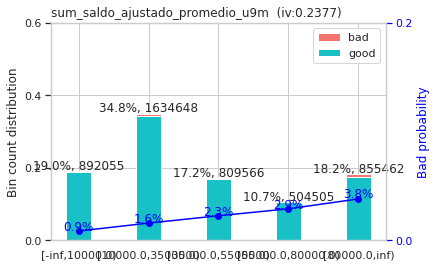

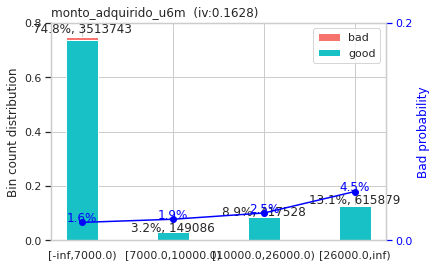

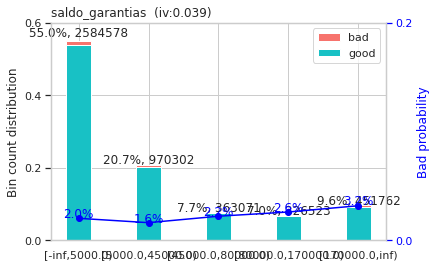

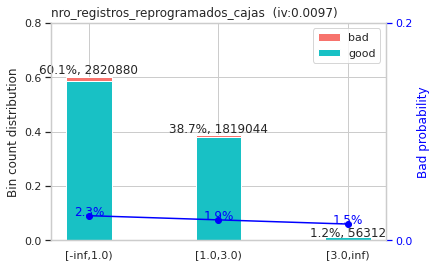

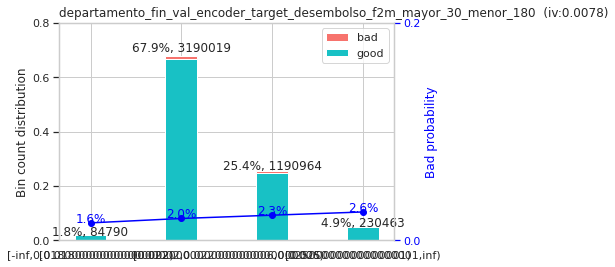

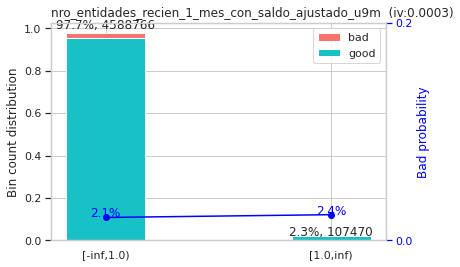

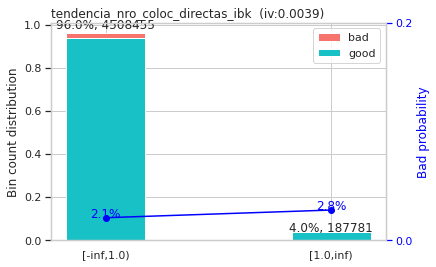

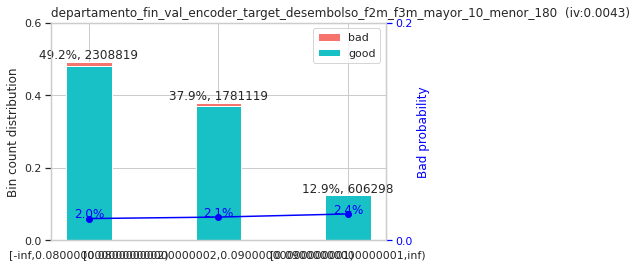

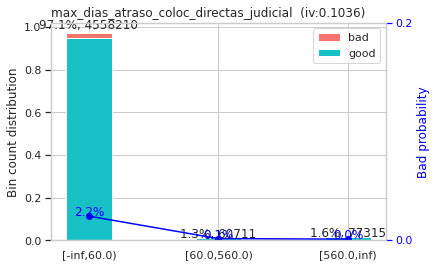

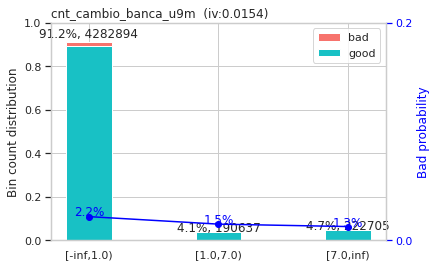

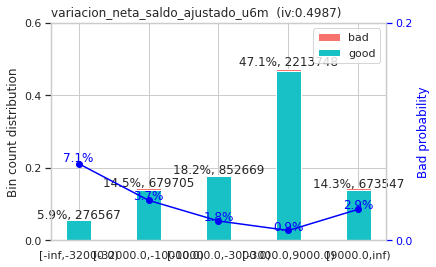

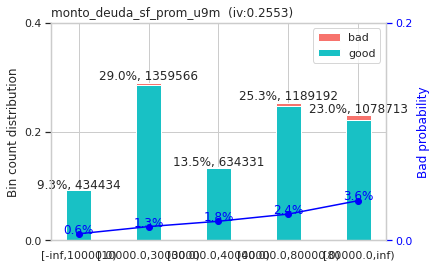

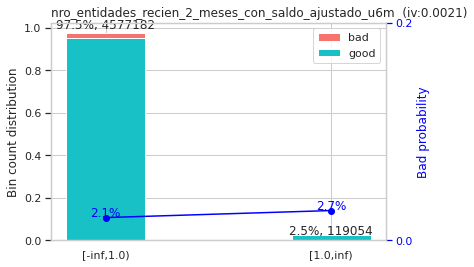

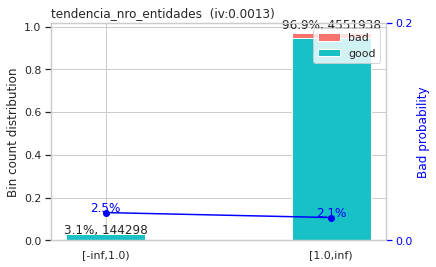

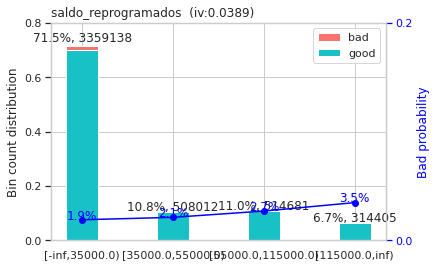

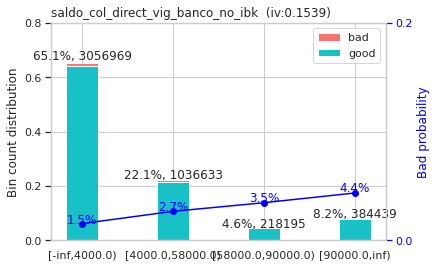

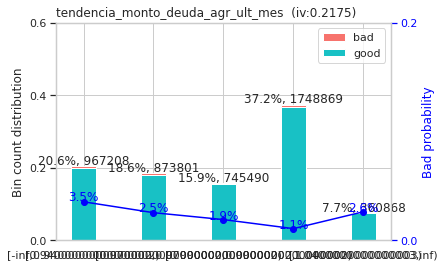

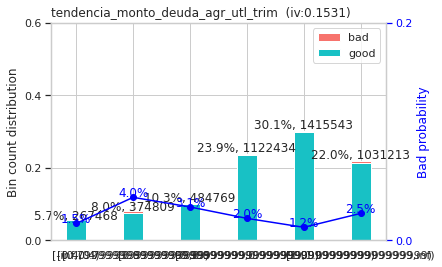

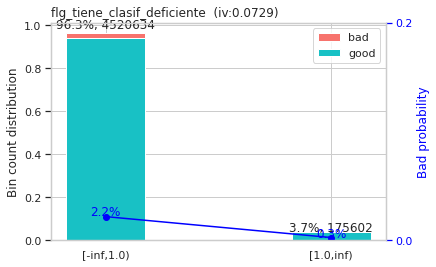

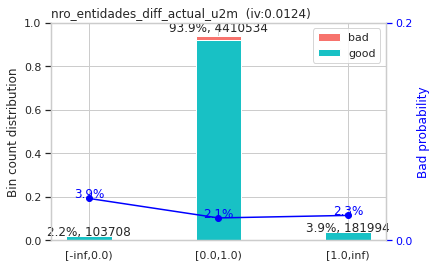

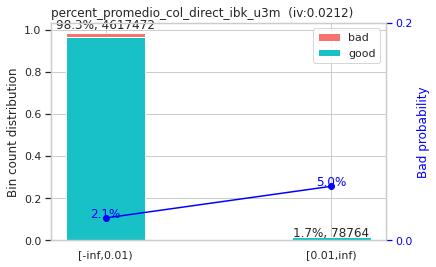

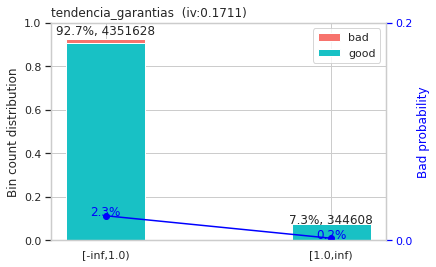

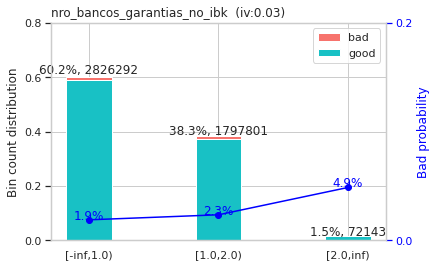

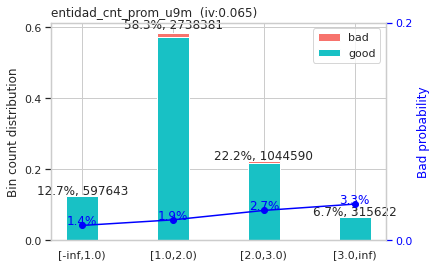

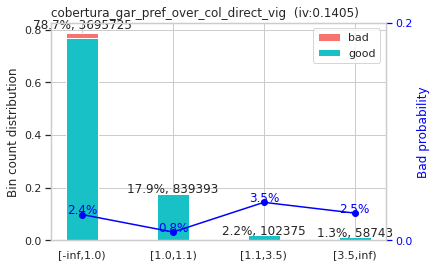

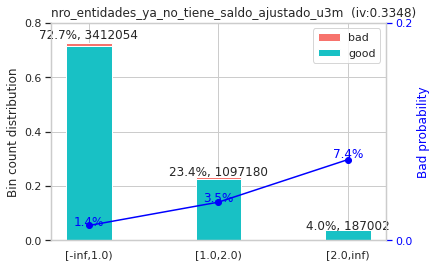

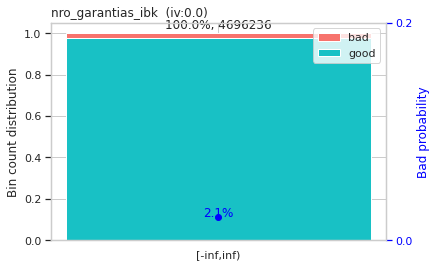

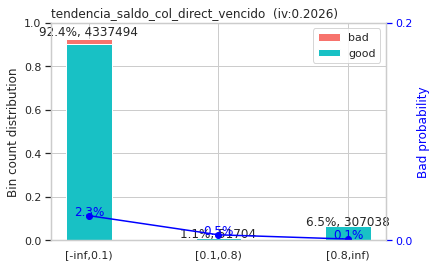

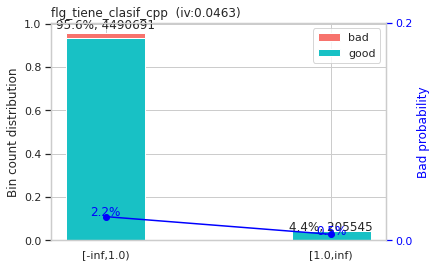

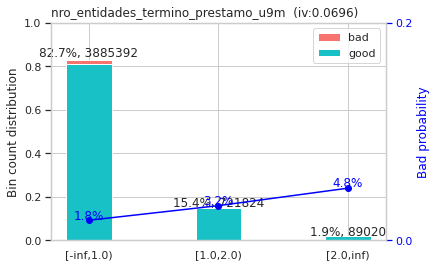

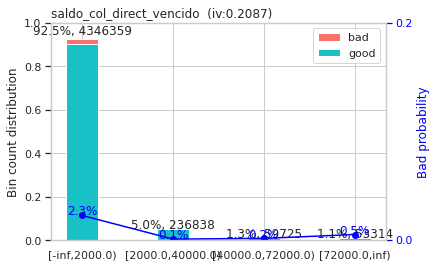

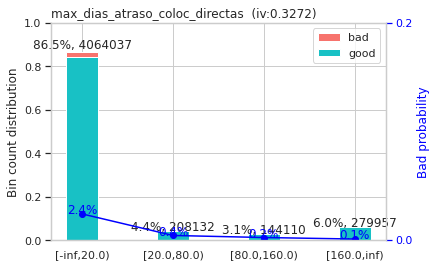

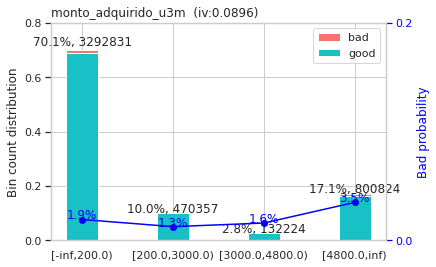

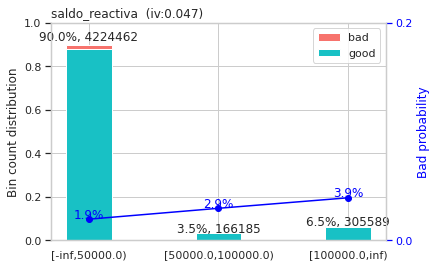

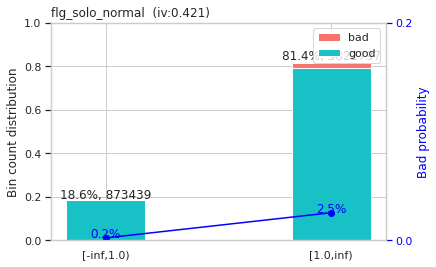

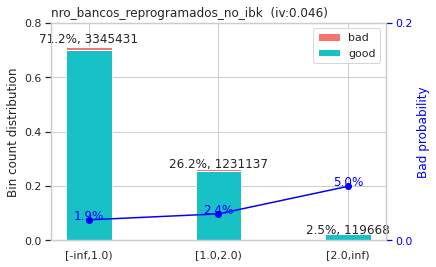

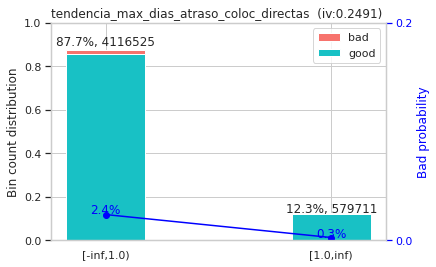

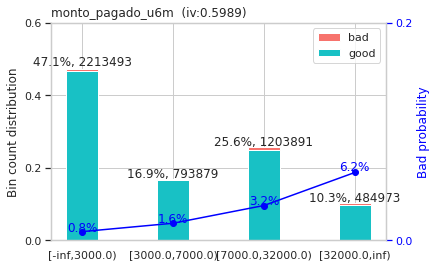

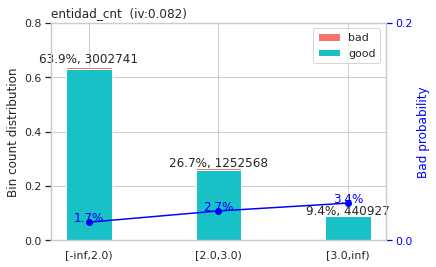

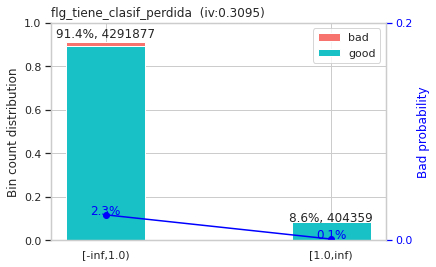

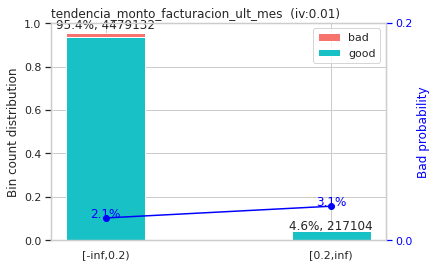

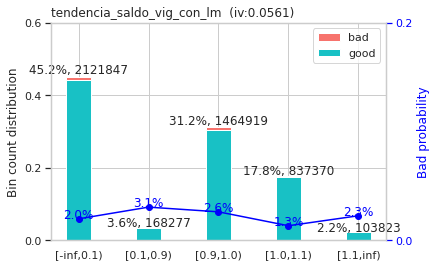

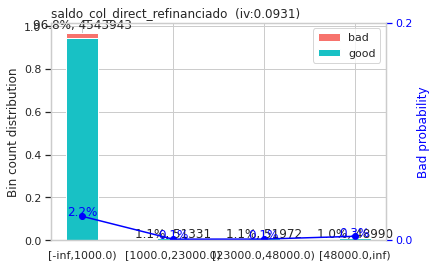

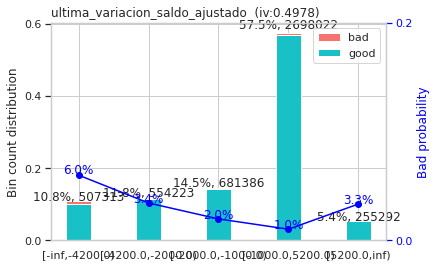

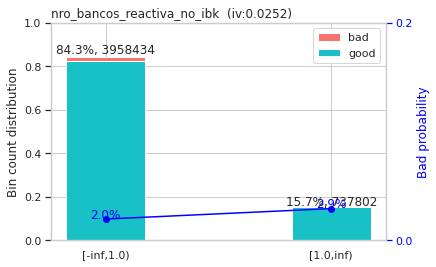

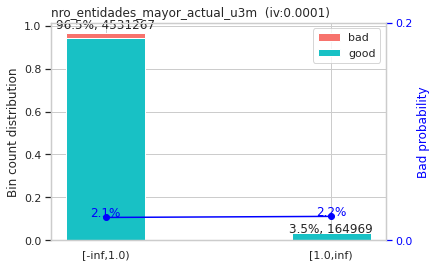

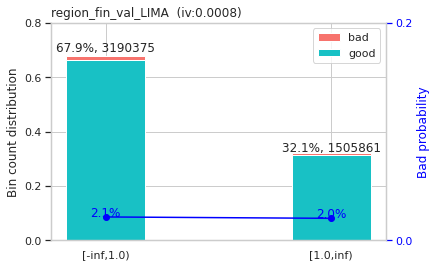

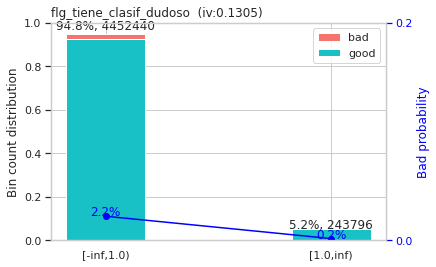

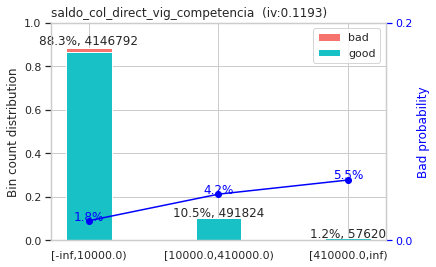

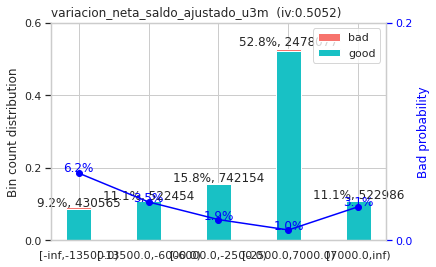

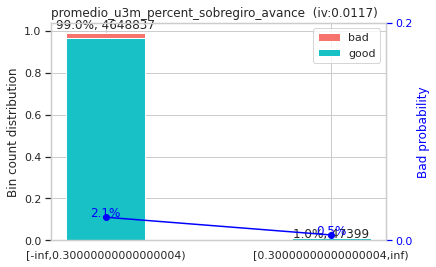

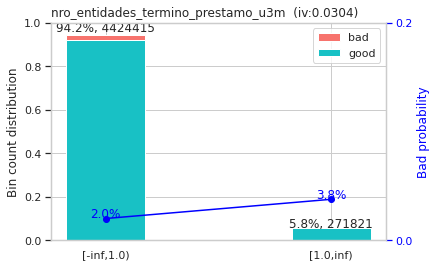

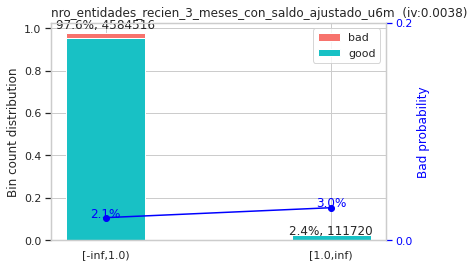

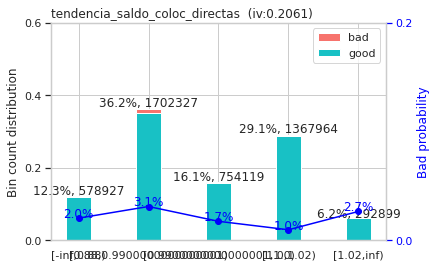

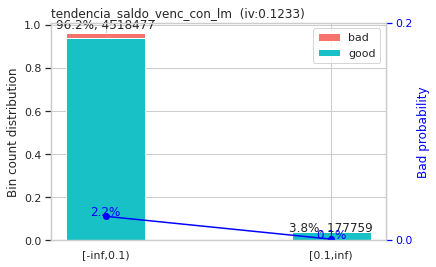

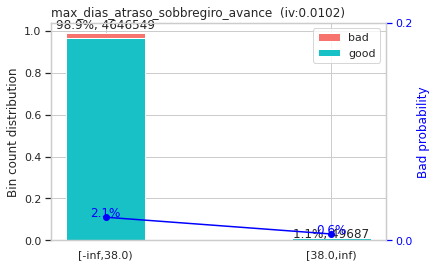

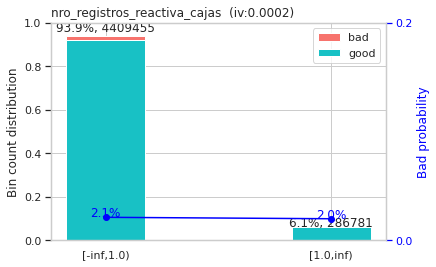

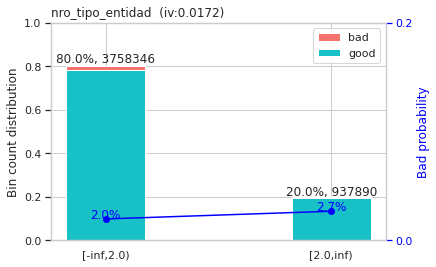

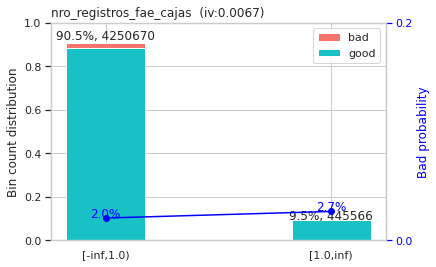

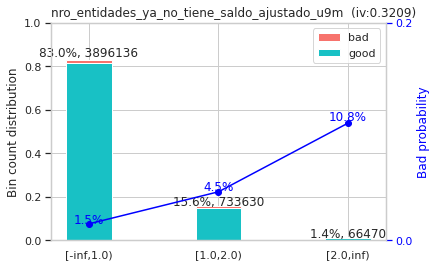

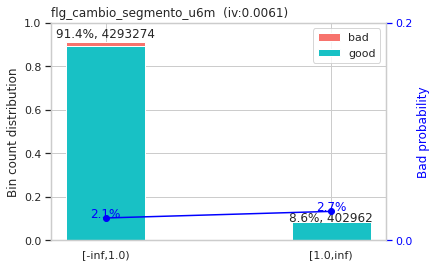

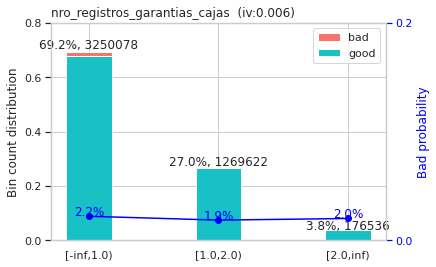

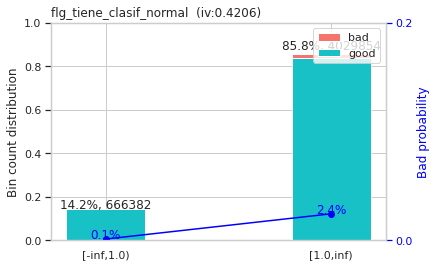

In [24]:
import scorecardpy as sc
sc.woebin_plot(woe_dict)

In [25]:
#content_object = s3.Object('bucket', woe.split(bucket)[-1][1:])
#file_content = content_object.get()['Body'].read().decode('utf-8')
#json_content = json.loads(file_content)

In [26]:
dupliccidad_signiicado = ['nro_entidades_ya_no_tiene_saldo_ajustado_u9m']

descarte = [
    'ultima_variacion_saldo_ajustado',
    'tendencia_monto_deuda_agr_ult_mes', 'tendencia_monto_deuda_agr_utl_trim',
    'monto_pagado_ult_rcc',  'variacion_neta_saldo_ajustado_u6m',
  'variacion_neta_saldo_ajustado_u3m'
]

len(dupliccidad_signiicado), len(descarte)

(1, 6)

In [27]:
selection = ['monto_pagado_u6m', 'nro_entidades_ya_no_tiene_saldo_ajustado_u3m',  'sum_saldo_ajustado_promedio_u9m', 
 'saldo_col_direct_vig_competencia', 'saldo_col_direct_vig_banco_no_ibk', 'nro_entidades_termino_prestamo_u9m', 'monto_adquirido_u6m',
  'nro_bancos_reprogramados_no_ibk', 'entidad_cnt', 'segmento_fin_val_S1',
 'segmento_fin_val_S2', 'entidad_cnt_prom_u9m', 'monto_adquirido_u3m', 'saldo_col_direct_vig_ibk', 'nro_bancos_garantias_no_ibk',
 'nro_entidades_termino_prestamo_u3m']

len(selection)

16